In [338]:
import pickle
from collections import defaultdict
import rankaggregation as ra

In [86]:
folder_main = 'data/recommendation'
folder = folder_main + '/lak'

### Open logs

In [430]:
folds = 5
fquestions = []
# fquestions_dict = []
q_dict = defaultdict(int)
for i in range(1, folds+1):
    with open('%s/test_fold_%d/7_5_0.1_0_0.01_0_0_0.01_0.01_1_0_0_0.1_30_3_1_50.log' % (folder,i), 
              'r') as logfile:
        logs = logfile.read()
        find = 'distribution of recommended items:'
        idx = logs.index(find) + len(find)
        
        q_idx = []
        for row in logs[idx:].split(']:')[1:]:
            row_count = row.split('\n')[0].split(',')
            try:
                q_dict[int(row_count[0])] += int(row_count[1])
                q_idx.append(row_count[0])
            except (ValueError, IndexError):
                pass
            
        fquestions.append(q_idx[::-1])
#         fquestions_dict.append(q_dict)

In [431]:
print("Top recommended questions:")
for fold in fquestions:
    print(fold[:3])
    
print("Least recommended questions:")
for fold in fquestions:
    print(fold[-10:])

Top recommended questions:
['9', '36', '37']
['9', '34', '10']
['9', '34', '10']
['9', '34', '36']
['9', '34', '4']
Least recommended questions:
['41', '26', '47', '18', '31', '43', '12', '33', '46', '11']
['8', '31', '38', '42', '26', '21', '30', '13', '18', '24']
['21', '46', '12', '8', '35', '24', '30', '38', '13', '47']
['8', '32', '38', '42', '16', '11', '3', '47', '22', '46']
['13', '36', '46', '26', '32', '47', '30', '0', '35', '39']


In [575]:
agg = ra.RankAggregator()
agg_result = agg.average_rank(fquestions)#, unranked='split')
rank_list = list(zip(*agg_result))
rank = [int(i) for i in rank_list[0]]
weight_list = rank_list[1]
print("Top recommended questions")
print(rank[:2])
print("Least recommended questions")
print(rank[-2:])
print("Avg recommeded questions")
print(rank[len(rank)//2-1:len(rank)//2+1])

Top recommended questions
[9, 34]
Least recommended questions
[35, 30]
Avg recommeded questions
[25, 14]


### Open reference pickle

In [576]:
with open('%s/single_resource_indexed_filtered_data.pkl' % folder, 'rb') as pklfile:
    data = pickle.load(pklfile)
    q_ids_ref = data['learning_material_id_mapping']

In [577]:
original_idx = [q_ids_ref[(0, int(question))][1] for question in rank]
print("Top recommended questions")
print(original_idx[:2])
print("Least recommended questions")
print(original_idx[-2:])
print("Avg recommeded questions")
print(original_idx[len(original_idx)//2-1:len(original_idx)//2+1])

Top recommended questions
[129, 130]
Least recommended questions
[63, 126]
Avg recommeded questions
[6, 11]


In [578]:
with open('%s/questions_idx.pkl' % folder, 'rb') as pklfile:
    questions_idx = pickle.load(pklfile)
    
with open('%s/q_matrix.pkl' % folder, 'rb') as pklfile:
    q_matrix = pickle.load(pklfile)
    
with open('%s/concept_idx.pkl' % folder, 'rb') as pklfile:
    concept_idx = pickle.load(pklfile)

In [579]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sort_distribution(df, columns, min_score=0.3):
    """ Sort topic assignment distribution """
    ids = []
    for col in columns:
        ids_col = np.where(df.idxmax(axis=1) == col)
        ids_col = df.loc[ids_col].sort_values([col], ascending=False).index.tolist()
        ids += ids_col

    df_sorted = df.loc[ids]
    return df_sorted

def normalize(matrix):
    """ Normalize sum per row """
    row_sums = matrix.sum()
    matrix_norm = matrix / row_sums
    return matrix_norm


def plot_distribution(df, cmap=sns.cm.rocket,
                       ylabel=None, title=None, savefig=None):

    # Create a figure instance, and the two subplots
#     fig = plt.figure(figsize=(8,10))
    fig = plt.figure()
    ax = fig.add_subplot(111)

    sns.heatmap(df, ax=ax, cmap=cmap, cbar_kws={'label': 'Concept probability'},
                robust=True, square=True)
    # use matplotlib.colorbar.Colorbar object
    cbar = ax.collections[0].colorbar
#     cbar.remove()
    # here set the labelsize by 20
#     cbar.ax.tick_params(labelsize=14)
#     cbar.ax.set_ylabel("Topic weight", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.xaxis.tick_top()
    ax.tick_params('x', labelrotation=90)
    ax.set_yticks([])

    if ylabel:
        ax.set_ylabel(ylabel, fontsize=14)

    if title:
        ax.set_title(title, fontsize=18, y=100)
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig + '.eps', format='eps')
        plt.savefig(savefig + '.png', format='png')
    plt.show()
    return None

In [580]:
concepts = Concept.objects.filter(pk__in=concept_idx).order_by('pk').values_list('label', flat=True)

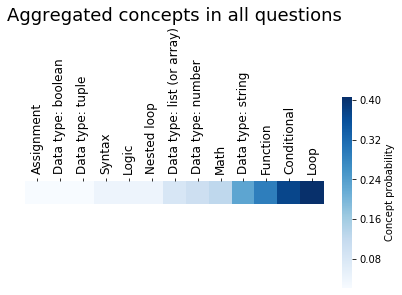

In [581]:
df = pd.Series(q_matrix.sum(axis=1)/q_matrix.shape[1], index=concepts).sort_values()
plot_distribution(df.to_frame().T, cmap='Blues', savefig="%s/regular" % folder, 
                  title="Aggregated concepts in all questions")

### Distribution considering all questions

In [582]:
weighted_qmatrix = q_matrix.copy()
for question, weight in q_dict.items():
# for question in q_dict.keys():
    original_id = q_ids_ref[(0, question)][1]
    q_matrix_id = questions_idx.index(original_id)
#     weight_idx = rank.index(str(question))
#     weight = 1/(weight_idx+1)
    weighted_qmatrix[:, q_matrix_id] += q_matrix[:, q_matrix_id] * weight

In [588]:
weighted_df = pd.Series(weighted_qmatrix.sum(axis=1)/sum(q_dict.values()), index=concepts).sort_values()
weighted_df = weighted_df.reindex(df.index)

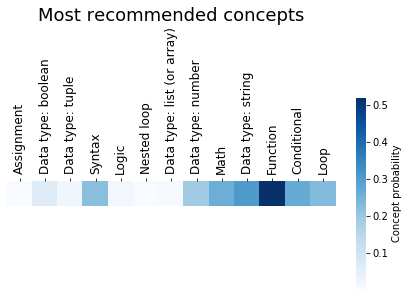

In [589]:
plot_distribution(weighted_df.to_frame().T, cmap='Blues', savefig="%s/all" % folder,
                 title="Most recommended concepts")

### Distribution considering top recommended questions

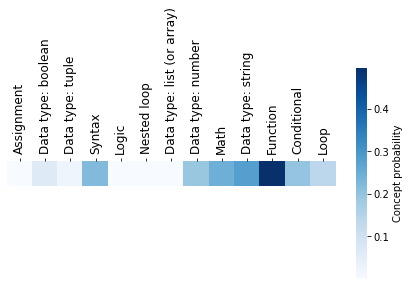

In [591]:
weighted_qmatrix = q_matrix.copy()
# for question, weight in q_dict.items():
for question in rank[:len(rank)//3]:
    original_id = q_ids_ref[(0, question)][1]
    q_matrix_id = questions_idx.index(original_id)
#     weight_idx = rank.index(str(question))
#     weight = 1/(weight_idx+1)
    weight = q_dict[question]
    weighted_qmatrix[:, q_matrix_id] += q_matrix[:, q_matrix_id] * weight
weighted_df = pd.Series(weighted_qmatrix.sum(axis=1)/sum(q_dict.values()), index=concepts).sort_values()
weighted_df = weighted_df.reindex(df.index)
plot_distribution(weighted_df.to_frame().T, cmap='Blues', savefig="%s/top" % folder)

In [642]:
0.2*48

9.600000000000001

In [647]:
sum(sorted(q_dict.values())[-10:])/sum(sorted(q_dict.values()))

0.7543776620918126

In [646]:
sum(sorted(q_dict.values())[-10:])

4782

In [618]:
for question in rank[:len(rank)//3]:
    original_id = q_ids_ref[(0, question)][1]
    p = Problem.objects.get(pk=original_id)
    print(p.content)

Define a function which can compute the sum of two numbers.
Define a function that can convert a integer into a string and return the string.
Write a function, which will find all such numbers between 1000 and 3000 (both included) such that each digit of the number is an even number.
The numbers obtained should be returned in a comma-separated sequence on a single line.

Create a function that receives as argument a decimal number up to 255 and convert it into its 8-bit binary equivalent.
Your function should return the 8-bit binary as a string, so you can add leading zeros. Make sure your binary number has 8 bits.

Write a function that receives as argument how many goals Team One scored and how many goals Team Two scored. Your function should return "Team One scores 3 points and Team Two scores 0 points." if Team One scored more goals than Team Two and vice-versa. If the number of goals is the same, the returned sentence should be "Both Team One and Team Two score 1 point.".

Create 

### Distribution considering avg recommended questions

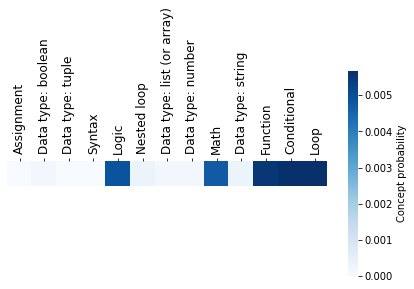

In [611]:
weighted_qmatrix = q_matrix.copy()
# for question, weight in q_dict.items():
for question in rank[len(rank)//3:2*len(rank)//3]:
    original_id = q_ids_ref[(0, question)][1]
    q_matrix_id = questions_idx.index(original_id)
#     weight_idx = rank.index(str(question))
#     weight = 1/(weight_idx+1)
    weight = q_dict[question]
    weighted_qmatrix[:, q_matrix_id] += q_matrix[:, q_matrix_id] * weight
weighted_df = pd.Series(weighted_qmatrix[:,len(rank)//3:2*len(rank)//3].sum(axis=1)/sum(q_dict.values()), index=concepts).sort_values()
weighted_df = weighted_df.reindex(df.index)
plot_distribution(weighted_df.to_frame().T, cmap='Blues', savefig="%s/avg" % folder)

In [632]:
for question in rank[len(rank)//3:2*len(rank)//3]:
    original_id = q_ids_ref[(0, question)][1]
    p = Problem.objects.get(pk=original_id)
    print(p.content)

Write a function that computes the net amount of a bank account based on a transaction log, which is passed as a list in the function argument.
The transaction log format is shown as following:
[('D', 100), ('W', 200)] where D means deposit while W means withdrawal.
Suppose the following input is supplied to the program:
[('D', 300), ('D', 300), ('W', 200), ('D', 100)]

Then, the output should be:
500
Write a program (using functions!) that receives as an argument a long string containing multiple words. The function should return the same string, except with the words in backwards order. For example, say I type the string:
  My name is Michele
Then I would see the string:
  Michele is name My
shown back to me.


Write a function that receives as argument a sentence and calculate the number of upper case letters and lower case letters.
Suppose the following input is supplied to the program:
Hello world!
Then, the output should be the dictionary:
{"uppercase": 1, "lowercase": 9}

Write 

### Distribution considering less recommended questions

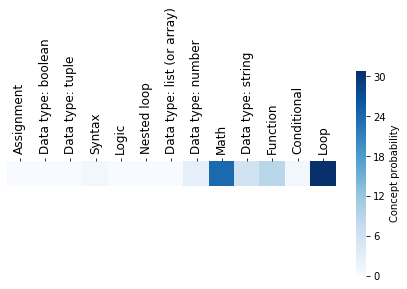

In [614]:
weighted_qmatrix = q_matrix.copy()
less_rec_qmatrix = []
for question in rank[2*len(rank)//3:]:
    original_id = q_ids_ref[(0, question)][1]
    q_matrix_id = questions_idx.index(original_id)
    less_rec_qmatrix.append(q_matrix[:, q_matrix_id])
    weight = q_dict[question]
    weighted_qmatrix[:, q_matrix_id] += q_matrix[:, q_matrix_id] * weight
weighted_df = pd.Series(weighted_qmatrix[:,2*len(rank)//3:].sum(axis=1), index=concepts)
# .sort_values()
weighted_df = weighted_df.reindex(df.index)
weighted_qmatrix[:,2*len(rank)//3:].sum(axis=1)
plot_distribution(weighted_df.to_frame().T, cmap='Blues', savefig="%s/least" % folder)

In [643]:
for question in rank[2*len(rank)//3:]:
    original_id = q_ids_ref[(0, question)][1]
    p = Problem.objects.get(pk=original_id)
    print(p.content)

Write a function that receives as argument a number and returns the factorial of the given number.
Suppose the following input is supplied to the program:
8
Then, the output should be:
40320


Write a function that receives as an argument how old the user is. Return a sentence saying "You are old enough to vote." if they are over 16 years old or "You can vote in X years.", substituting the X with the appropriate number of years. Add another sentence if the user is younger than 65 years old, calculating the number of years missing until they can retire (assume at age 65): "You can retire in Y years.".
Write a function that takes as argument a list (for example: numlist = [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]) and returns only the elements of the list that are less than 5.
Write a function that receives as argument a month (from 1 to 12) and returns its season. Remembering:
a) December, January and February are summer
b) March, April and May are autumn
c) June, July and August are winte

In [604]:
concepts

<QuerySet ['Syntax', 'Assignment', 'Data type: number', 'Data type: boolean', 'Math', 'Logic', 'Data type: string', 'Data type: list (or array)', 'Data type: tuple', 'Conditional', 'Loop', 'Nested loop', 'Function']>

In [601]:
less_rec_qmatrix

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]

In [519]:
import imageio
images = []
filenames = ["top", "avg", "least"]
for filename in filenames:
    images.append(imageio.imread("%s/%s.eps" % (folder, filename)))
imageio.mimsave('%s/movie.gif' % folder, images, duration=1)

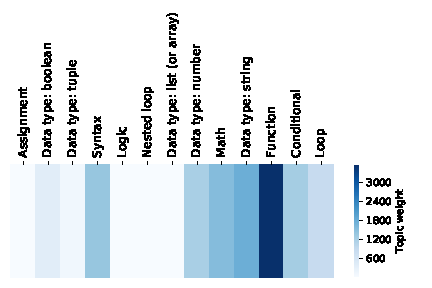

In [520]:
from IPython.display import Image
Image(filename="%s/movie.gif" % folder)